In [10]:
import csv
import itertools
import pandas as pd
import numpy as np
import networkx as nx

## Hypergraph to regular graph

In [11]:
papers=[]
with open("train.txt", "r") as f:
    for x in f:
        token_list=x.rstrip("\n").split()
        papers.append(token_list)

In [60]:
np.random.seed(27)
np.random.shuffle(papers)


trainPapers = papers[2300:]
devPapers = papers[:2300]

def hyper2simple(papers):
    graph=[]
    for paper in papers:
        for pair in itertools.combinations(paper, 2):
            graph.append(pair)

    graph_df=pd.DataFrame(graph, columns=['Author_A','Author_B'])
    #Calculate weights
    g_df = graph_df.groupby(['Author_A','Author_B']).size().reset_index().rename(columns={0:'count'})
    #create undirectional graph 
    ng = nx.convert_matrix.from_pandas_edgelist(g_df, source= 'Author_A', target = 'Author_B', edge_attr= 'count')
    return ng, g_df

ng, df_pos = hyper2simple(trainPapers)
dev_ng, df_dev = hyper2simple(devPapers)
print(nx.info(ng))


Name: 
Type: Graph
Number of nodes: 3455
Number of edges: 12756
Average degree:   7.3841


In [39]:
print(nx.info(dev_ng))

Name: 
Type: Graph
Number of nodes: 2218
Number of edges: 6000
Average degree:   5.4103


## Create negative samples

In [61]:
%%time
###generating negative edges from given graph
def negativeSampleGenerator(g_df, ng):
    import random
    
    edges = {i:1 for i in zip(g_df.Author_A,g_df.Author_B)}

    authorlist_A = list(set(g_df['Author_A'].to_list()))
    authorlist_B = list(set(g_df['Author_B'].to_list()))
    random.seed(1687)
    missing_edges = set([])
    while (len(missing_edges)<g_df.shape[0]): # such that same number as positive edges
        a=random.choice(authorlist_A) # as the authorlist in the train set, contains all possible authors.
        b=random.choice(authorlist_B)
        tmp = edges.get((a,b),-1)
        if tmp == -1 and a!=b:
            try:
                if nx.shortest_path_length(ng,source=a,target=b) > 2 and (a,b) not in missing_edges and (b,a) not in missing_edges: 

                    missing_edges.add((a,b))
                else:
                    continue  
            except:
                if (a,b) not in missing_edges and (b,a) not in missing_edges:
                    missing_edges.add((a,b))              
        else:
            continue
    df_neg = pd.DataFrame(list(missing_edges), columns=['Author_A', 'Author_B'])
    df_neg = df_neg.groupby(['Author_A','Author_B']).size().reset_index().rename(columns={0:'count'})
    df_neg['Author_A'] = df_neg['Author_A'].astype(str)
    df_neg['Author_B'] = df_neg['Author_B'].astype(str)
    
    return df_neg

df_neg = negativeSampleGenerator(df_pos, ng)
df_dev_neg = negativeSampleGenerator(df_dev, dev_ng) #check if should we use ng or dev_ng

Wall time: 1.2 s


In [62]:
print(df_pos.shape, df_dev.shape)

(12756, 3) (6017, 3)


In [63]:
print(df_neg.shape, df_dev_neg.shape)

(12756, 3) (6017, 3)


### Comparing negative and positive graphs

!!!!!!!!!!!!!!!!!!!!!!!!!!! 
Although is not required to create a negative graph, as we need to calculate each negative edge as it was an edge in the orginal graph

#### Positive graph

In [6]:
nx.number_connected_components(ng)

142

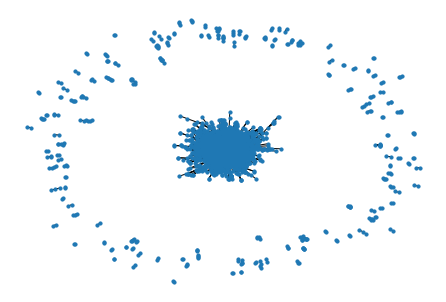

In [7]:
import matplotlib as plt
nx.draw_spring(ng,node_size = 10)

In [33]:
import matplotlib.pyplot as plt
import collections

def plot_degree(G):
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color="b");

    plt.title("Degree Histogram")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg);


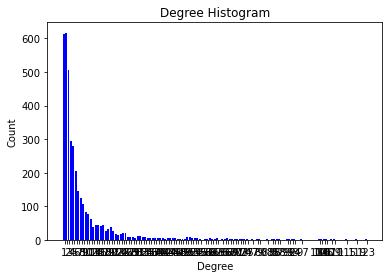

In [34]:
plot_degree(ng)

#### negative graph

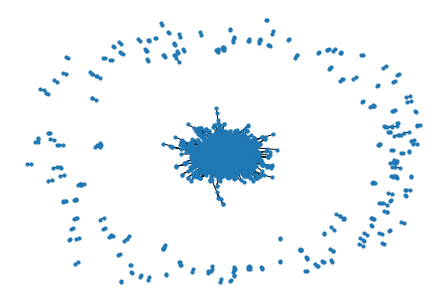

In [35]:
nx.draw_spring(dev_ng,node_size = 10)

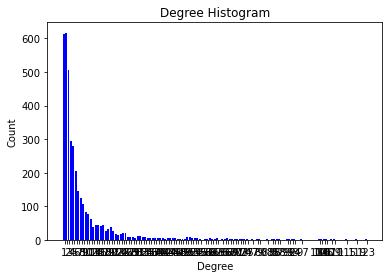

In [36]:
plot_degree(dev_ng)

## Calculate features

In [18]:
def feature_maker(edges):
    features = []
    for pair in edges:
        feat = []
        tmp_ng = ng.copy()
        
        #Add an edge to the network if node is not in training
        if not (ng.has_node(pair[0]) and ng.has_node(pair[1])):
            tmp_ng.add_edge(pair[0],pair[1])
        
        # Calculate features
        try:
            metric = nx.adamic_adar_index(tmp_ng, [pair])
            for s,t,m in metric:
                feat.append(m)
        except:
            feat.append(0)
        try:
            metric = nx.resource_allocation_index(tmp_ng, [pair])
            for s,t,m in metric:
                feat.append(m)
        except:
            feat.append(0)
        try:
            metric = nx.jaccard_coefficient(tmp_ng, [pair])
            for s,t,m in metric:
                feat.append(m)
        except:
            feat.append(0)
        try:
            metric = nx.preferential_attachment(tmp_ng, [pair])
            for s,t,m in metric:
                feat.append(m)
        except:
            feat.append(0)
            
        features.append(feat)
    return features       

In [7]:
def feature_maker2(edges):
    features = []
    between_centrality=nx.betweenness_centrality(ng)
    for pair in edges:
        feat = []
        tmp_ng = ng.copy()
        between_centrality_tmp={}
        #Add an edge to the network if node is not in training
        if not (ng.has_node(pair[0]) and ng.has_node(pair[1])):
            tmp_ng.add_edge(pair[0],pair[1])
            #print('not in network')
            between_centrality_tmp=nx.betweenness_centrality(tmp_ng)
        
        # Calculate features
        #Calculates length of the shortest path between 
        try:
            distance=nx.shortest_path_length(tmp_ng,source=pair[0],target=pair[1])
            #print('calculated short path for nodes',pair[0],'and',pair[1])
            feat.append(distance)
        except:
            feat.append(999)
        try:
            if len(between_centrality_tmp)==0:
                feat.append(between_centrality[pair[0]]) #Between centrality author A on original network
                feat.append(between_centrality[pair[1]]) #Between centrality author B on original network
            else:
                feat.append(between_centrality_tmp[pair[0]]) #Between centrality author A on altered network
                feat.append(between_centrality_tmp[pair[1]]) #Between centrality author B on altered network                           
        except:
            feat.append(0)
            feat.append(0)
#         try:
#             metric = nx.jaccard_coefficient(tmp_ng, [pair])
#             for s,t,m in metric:
#                 feat.append(m)
#         except:
#             feat.append(0)
#         try:
#             metric = nx.preferential_attachment(tmp_ng, [pair])
#             for s,t,m in metric:
#                 feat.append(m)
#         except:
#             feat.append(0)    
        features.append(feat)
    return features 

In [30]:
def feature_maker3(edges):
    features = []
    #degree_centrality=nx.degree_centrality(ng)
    #closeness_centrality = nx.closeness_centrality(ng)
    hits = nx.hits(ng, max_iter=500)
    #print(hits)
    for pair in edges:
        feat = []
        tmp_ng = ng.copy()
        #degree_centrality_tmp={}
        #closeness_centrality_tmp = {}
        hits_tmp = {}
        #Add an edge to the network if node is not in training
        if not (ng.has_node(pair[0]) and ng.has_node(pair[1])):
            tmp_ng.add_edge(pair[0],pair[1])
            #print('not in network')
            #degree_centrality_tmp = nx.degree_centrality(tmp_ng)
            #closeness_centrality_tmp = nx.closeness_centrality(tmp_ng)
            hits_tmp = nx.hits(tmp_ng, max_iter=500)
            
        # Calculate features
        """
        try:
            if len(degree_centrality_tmp)==0:
                feat.append(degree_centrality[pair[0]]) #degree centrality author A on original network
                feat.append(degree_centrality[pair[1]]) #degree centrality author B on original network
            else:
                feat.append(degree_centrality_tmp[pair[0]]) #degree centrality author A on altered network
                feat.append(degree_centrality_tmp[pair[1]]) #degree centrality author B on altered network 
        except:
            feat.append(0)
            feat.append(0)
        try:
            if len(closeness_centrality_tmp)==0:
                feat.append(closeness_centrality[pair[0]]) #closeness centrality author A on original network
                feat.append(closeness_centrality[pair[1]]) #closeness centrality author B on original network
            else:
                feat.append(closeness_centrality_tmp[pair[0]]) #closeness centrality author A on altered network
                feat.append(closeness_centrality_tmp[pair[1]]) #closeness centrality author B on altered network 
                
        except:
            feat.append(0)
            feat.append(0)
        """
        try:
            if len(hits_tmp)==0:
                feat.append(hits[0][pair[0]]) #hits A
                feat.append(hits[1][pair[0]]) #authorities A
                feat.append(hits[0][pair[1]]) #hits B
                feat.append(hits[1][pair[1]]) #authorities B
            else:
                feat.append(hits_tmp[0][pair[0]]) #hits A
                feat.append(hits_tmp[1][pair[0]]) #authorities A
                feat.append(hits_tmp[0][pair[1]]) #hits B
                feat.append(hits_tmp[1][pair[1]]) #authorities B
        except:
            feat.append(0)
            feat.append(0)
            feat.append(0)
            feat.append(0)
            
        features.append(feat)
    return features 

In [10]:
def feature_maker4(edges):
    features = []
    common_neighbour=nx.common_neighbor_centrality(ng)
    for pair in edges:
        feat = []
        tmp_ng = ng.copy()
        common_neighbour_tmp={}
        #Add an edge to the network if node is not in training
        if not (ng.has_node(pair[0]) and ng.has_node(pair[1])):
            tmp_ng.add_edge(pair[0],pair[1])
            #print('not in network')
            common_neighbour_tmp = nx.common_neighbor_centrality(tmp_ng)
        
        # Calculate features
        try:
            if len(common_neighbour_tmp)==0:
                for common_neighbour
                for u,v,p in common_neighbour:
                    feat.append(p)
            else:
                feat.append(degree_centrality_tmp[pair[0]]) #degree centrality author A on altered network
                feat.append(degree_centrality_tmp[pair[1]]) #degree centrality author B on altered network 
        except:
            feat.append(0)
            feat.append(0)

## File name format

In [ ]:
## train-comm_neighbour-degree_central_A_B.csv 

In [ ]:
common_neighbour=nx.common_neighbor_centrality(ng)

## Apply features to datsets

In [41]:
test_df = pd.read_csv('test-public.csv')

In [42]:
#trainset pos
edges = [(i,e) for i,e in zip(df_pos.Author_A, df_pos.Author_B)]
featp = feature_maker(edges)
featp = pd.DataFrame(featp, columns = ['aa','ra','jc','pa'])
df_posR = pd.concat([df_pos, featp], axis = 1)

In [55]:
%%time
#trainset neg
edges = [(i,e) for i,e in zip(df_neg.Author_A, df_neg.Author_B)]
featn = feature_maker(edges)
featn = pd.DataFrame(featn, columns = ['aa','ra','jc','pa'])
df_negR = pd.concat([df_neg, featn], axis = 1)

Wall time: 9min 36s


In [56]:
df_posR['label'] = [1 for i in range(df_posR.shape[0])]
df_negR['label'] = [0 for i in range(df_negR.shape[0])]
df_train = pd.concat([df_posR, df_negR], axis = 0)
df_train.to_csv('train1.csv')

In [45]:
#Dev set pos
edges = [(i,e) for i,e in zip(df_dev.Author_A, df_dev.Author_B)]
featdp = feature_maker(edges)
featdp = pd.DataFrame(featdp, columns = ['aa','ra','jc','pa'])
df_devR = pd.concat([df_dev, featdp], axis = 1)

In [57]:
#devset neg
edges = [(i,e) for i,e in zip(df_dev_neg.Author_A, df_dev_neg.Author_B)]
featdn = feature_maker(edges)
featdn = pd.DataFrame(featdn, columns = ['aa','ra','jc','pa'])
df_dev_negR = pd.concat([df_dev_neg, featdn], axis = 1)

In [58]:
df_devR['label'] = [1 for i in range(df_devR.shape[0])]
df_dev_negR['label'] = [0 for i in range(df_dev_negR.shape[0])]
df_devop = pd.concat([df_devR, df_dev_negR], axis = 0)
df_devop.to_csv('dev1.csv')

In [48]:
#test set
edges = [(str(i),str(e)) for i,e in zip(test_df.Source, test_df.Sink)]
featt = feature_maker(edges)
featt = pd.DataFrame(featt, columns = ['aa','ra','jc','pa'])
test_dfR = pd.concat([test_df, featt], axis = 1)
test_dfR.to_csv("test1.csv")

### other old Staff

In [32]:
#Positive instances
edges = [(i,e) for i,e in zip(df_pos.Author_A, df_pos.Author_B)]
"""
feat = feature_maker(edges)
feat = pd.DataFrame(feat, columns = ['aa','ra','jc','pa'])
feat2 = feature_maker2(edges)
feat2 = pd.DataFrame(feat2, columns = ['path_len','bet_cA','bet_cB'])
"""
feat3 = feature_maker3(edges)
feat3 = pd.DataFrame(feat3, columns = ['hits_A','authorities_A','hits_B','authorities_B'])
"""
feat4 = feature_maker4(edges)
feat4 = pd.DataFrame(feat4, columns = ['common_neigh_centr'])
"""
#df_pos2 = pd.concat([df_pos, feat,feat2], axis = 1)
df_pos2 = pd.concat([df_pos, feat3], axis = 1)
df_pos2

,Author_A,Author_B,count,hits_A,authorities_A,hits_B,authorities_B
0,0,1236,14,0.000003,0.000003,0.000057,0.000057
1,0,1655,9,0.000003,0.000003,0.000011,0.000011
2,0,1797,4,0.000003,0.000003,0.000003,0.000003
3,0,2414,1,0.000003,0.000003,0.000002,0.000002
4,0,2568,8,0.000003,0.000003,0.000018,0.000018
...,...,...,...,...,...,...,...
16031,999,2038,1,0.000229,0.000229,0.000807,0.000807
16032,999,2250,4,0.000229,0.000229,0.000227,0.000227
16033,999,2600,1,0.000229,0.000229,0.000117,0.000117
16034,999,2905,3,0.000229,0.000229,0.000045,0.000045


In [31]:
prueba=feature_maker3([('0','1236')])
print(prueba)

[[3.1662441796204187e-06, 3.1662441797505687e-06, 5.7136290686742184e-05, 5.713629068892072e-05]]


In [33]:
#Negative instances
edges = [(i,e) for i,e in zip(df_neg.Author_A, df_neg.Author_B)]
"""
feat = feature_maker(edges)
feat = pd.DataFrame(feat, columns = ['aa','ra','jc','pa'])
feat2 = feature_maker2(edges)
feat2 = pd.DataFrame(feat2, columns = ['path_len','bet_cA','bet_cB'])
"""
feat3 = feature_maker3(edges)
feat3 = pd.DataFrame(feat3, columns = ['hits_A','authorities_A','hits_B','authorities_B'])
"""
feat4 = feature_maker4(edges)
feat4 = pd.DataFrame(feat4, columns = ['common_neigh_centr'])
"""
#df_neg2 = pd.concat([df_neg, feat, feat2], axis = 1)
df_neg2 = pd.concat([df_neg, feat3], axis = 1)
df_neg2

,Author_A,Author_B,count,hits_A,authorities_A,hits_B,authorities_B
0,0,1044,1,0.000003,0.000003,4.560257e-06,4.560257e-06
1,0,2477,1,0.000003,0.000003,8.384335e-07,8.384335e-07
2,0,2757,1,0.000003,0.000003,2.879278e-04,2.879278e-04
3,0,2860,1,0.000003,0.000003,2.014412e-04,2.014412e-04
4,0,3338,1,0.000003,0.000003,3.075000e-04,3.075000e-04
...,...,...,...,...,...,...,...
16031,999,1831,1,0.000229,0.000229,4.054785e-04,4.054785e-04
16032,999,204,1,0.000229,0.000229,5.737906e-07,5.737906e-07
16033,999,2682,1,0.000229,0.000229,3.291513e-05,3.291513e-05
16034,999,3483,1,0.000229,0.000229,2.258293e-05,2.258293e-05


In [34]:
df_train = pd.concat([df_pos2, df_neg2], axis = 0)
#df_train.to_csv('train_transformed7feat.csv')
df_train.to_csv('train_add_hits.csv')

In [35]:
#Test set
edges = [(str(i),str(e)) for i,e in zip(test_df.Source, test_df.Sink)]
"""
feat = feature_maker(edges)
feat = pd.DataFrame(feat, columns = ['aa','ra','jc','pa'])
feat2 = feature_maker2(edges)
feat2 = pd.DataFrame(feat2, columns = ['path_len','bet_cA','bet_cB'])
"""
feat3 = feature_maker3(edges)
feat3 = pd.DataFrame(feat3, columns = ['hits_A','authorities_A','hits_B','authorities_B'])
"""
feat4 = feature_maker4(edges)
feat4 = pd.DataFrame(feat4, columns = ['common_neigh_centr'])
#test = pd.concat([test_df, feat, feat2], axis =1)
"""
test = pd.concat([test_df, feat3], axis =1)   


#test.to_csv('test_transformed7feat.csv')
test.to_csv('test_add_hits.csv')

# OLD STUFF

In [ ]:
"""
tested features


"""
feature_1 = []
metric = nx.common_neighbor_centrality(ng)
for s,t in ng.edges():
    try:
        for u,v,p in metric:
            feature_1.append(p)
    except:
        feature_1.append(0)

katz = nx.katz.katz_centrality(ng)
# Katz centrality Author_A - doesn't converge.
feature_10 = []
for s,t in ng.edges():
    try:
        kc = katz[s]
        feature_10.append(kc)
    except:
        feature_10.append(0)

# Katz centrality Author_B
feature_11 = []
for s,t in ng.edges():
    try:
        kc = katz[t]
        feature_11.append(kc)
    except:
        feature_11.append(0)

katz = nx.katz.katz_centrality(ng_neg)
# Katz centrality Author_A neg edges.
feature_10_neg = []
for s,t in ng_neg.edges():
    try:
        kc = katz[s]
        feature_10_neg.append(kc)
    except:
        feature_10_neg.append(0)

# Katz centrality Author_B neg edges.
feature_11_neg = []
for s,t in ng_neg.edges():
    try:
        kc = katz[t]
        feature_11_neg.append(kc)
    except:
        feature_11_neg.append(0)

In [34]:
def extract_feats(g, ds = 'train'):
    btwc = nx.edge_betweenness_centrality(g)
    feature_2 = []
    feature_3 = []
    cc = nx.closeness_centrality(g)
    feature_4 = []
    dc = nx.degree_centrality(g)
    feature_5 = []
    feature_6 = []
    feature_7 = []
    pr = nx.pagerank(g)
    # pagerank Author_A.
    feature_8 = []
    # pagerank Author_B.
    feature_9 = []
    hits = nx.hits(g, max_iter=500)
    # for Author A.
    feature_12 = []
    feature_13 = []
    # for Author B.
    feature_14 = []
    feature_15 = []
    
    for s,t in g.edges():
        if g.get_edge_data(s, t)['dataset'] == ds:
            try:
                feature_2.append(btwc[(str(s),str(t))])
                metric = nx.adamic_adar_index(g, [(s,t)])

                for u,v,p in metric:
                    feature_3.append(p)
                feature_4.append(cc[str(s)])
                feature_5.append(dc[str(s)])

                metric = nx.jaccard_coefficient(g, [(s,t)])
                for u,v,p in metric:
                    feature_6.append(p)
                metric = nx.preferential_attachment(g, [(s,t)])
                for u,v,p in metric:
                    feature_7.append(p)
                rank = pr[s]
                feature_8.append(rank)
                rank = pr[t]
                feature_9.append(rank)
                hit_i = hits[0][s]
                hit_j = hits[1][s]
                feature_12.append(hit_i)
                feature_13.append(hit_j)
                hit_i = hits[0][t]
                hit_j = hits[1][t]
                feature_14.append(hit_i)
                feature_15.append(hit_j)
            except:
                feature_2.append(0)
                feature_3.append(0)
                feature_4.append(0)
                feature_5.append(0)
                feature_6.append(0)
                feature_7.append(0)
                feature_8.append(0)
                feature_9.append(0)
                feature_12.append(0)
                feature_13.append(0)
                feature_14.append(0)
                feature_15.append(0)
    return feature_2, feature_3, feature_4, feature_5, feature_6, feature_7, feature_8, feature_9, feature_12, feature_13, feature_14, feature_15  


# need "community" information for that. Do we have that piece of information?
#wic = nx.within_inter_cluster(ng)

In [ ]:
#df_pos['cnc'] = feature_1
df_pos['btwc'] = feature_2(ng)
df_pos['adar'] = feature_3(ng)
df_pos['cc'] = feature_4(ng)
df_pos['dc'] = feature_5(ng)
df_pos['jc'] = feature_6(ng)
df_pos['pa'] = feature_7(ng)
df_pos['pagerank_A'] = feature_8(ng)
df_pos['pagerank_B'] = feature_9(ng)
#df_pos['katz_A'] = feature_10
#df_pos['katz_B'] = feature_11
df_pos['hits_authority_A'], df_pos['hits_hubs_A'] = feature_12_13(ng)
df_pos['hits_authority_B'], df_pos['hits_hubs_B'] = feature_14_15(ng)
#df_neg['cnc'] = feature_1_neg
df_neg['btwc'] = feature_2(ng_neg)
df_neg['adar'] = feature_3(ng_neg)
df_neg['cc'] = feature_4(ng_neg)
df_neg['dc'] = feature_5(ng_neg)
df_neg['jc'] = feature_6(ng_neg)
df_neg['pa'] = feature_7(ng_neg)
df_neg['pagerank_A'] = feature_8(ng_neg)
df_neg['pagerank_B'] = feature_9(ng_neg)
#df_neg['katz_A'] = feature_10_neg
#df_neg['katz_B'] = feature_11_neg
df_neg['hits_authority_A'], df_neg['hits_hubs_A'] = feature_12_13(ng_neg)
df_neg['hits_authority_B'], df_neg['hits_hubs_B'] = feature_14_15(ng_neg)

In [152]:
import pickle
df_pos.to_csv("pos_training_data.csv")
df_neg.to_csv("neg_training_data.csv")
with open('pos_training_labels.ob', 'wb') as fp:
    pickle.dump(y_pos, fp)
with open('neg_training_labels.ob', 'wb') as fp:
    pickle.dump(y_neg, fp)
df_final_train = df_pos.append(df_neg,ignore_index=True)
y_final_train = np.concatenate((y_pos,y_neg))
df_final_train.to_csv("training_data_combined.csv")
with open('training_labels_combined.ob', 'wb') as fp:
    pickle.dump(y_final_train, fp)

In [ ]:
df_final_train = pd.read_csv("training_data_combined.csv")

### Transform test set

#### First try of gettin mixing test and train network to calculate features properly. Didnt work

In [82]:
# public test data transformation.
for s,t in ng.edges():
    nx.set_edge_attributes(ng, {(s,t):{'dataset':'train'}})
test_df = pd.read_csv('test-public.csv')
test_df.drop(test_df.columns[[0]], axis=1, inplace=True)
test_df.columns = ['Author_A','Author_B']
test_df = test_df.groupby(['Author_A','Author_B']).size().reset_index().rename(columns={0:'count'})
test_df['dataset'] = ['test' for i in range(test_df.shape[0])]
#create undirectional graph 
ng_test = nx.convert_matrix.from_pandas_edgelist(test_df, source= 'Author_A', target = 'Author_B', edge_attr= ['count','dataset'])
ng_test = nx.union(ng,ng_test)

test_df['btwc'], test_df['adar'], test_df['cc'], test_df['dc'], test_df['jc'], test_df['pa'], test_df['pagerank_A'], test_df['pagerank_B'],test_df['hits_authority_A'], test_df['hits_hubs_A'],test_df['hits_authority_B'], test_df['hits_hubs_B']  = extract_feats(ng_test, 'test')

KeyboardInterrupt: 